# LAB 7: Error analysis

Objectives
* Construct a  linear text classifier using SGDClassifier
* Evaluate its performance and categorize the errors that it makes
* Eaxmine model's coefficients and decision function values
* Interpret model results using LIME

In [1]:
import pickle

import cloudpickle
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm

tqdm.pandas()

---

## Load data

In [2]:
train, test = pickle.load(open("/data/politics.pkl", "rb"))

In [3]:
sgd = cloudpickle.load(open("sgd.model", "rb"))
svm = cloudpickle.load(open("svm.model", "rb"))

---

## Decision function

In [4]:
from sklearn.metrics import classification_report, f1_score

In [5]:
labels = sgd.named_steps["sgdclassifier"].classes_
scores = sgd.decision_function(test["text"])

predicted = sgd.predict(test["text"])

In [6]:
test["pol"].iloc[0], predicted[0]

(True, True)

In [7]:
test["text"].iloc[0]

'China says U.S. wrong over donation reports. China on Monday dismissed suggestions it had paid political donations to the U.S. Democratic Party and slammed Washington for taking what it said were irresponsible and wrong actions over the issue. A senior Chinese foreign ministry official had made serious representations to the U.S. charge d\'affairs in Beijing over U.S. actions that had created bad feeling and undermined relations, the official Xinhua news agency said.   The Washington Post reported on Sunday that the Federal Bureau of Investigation had warned six members of Congress last year that they had been targeted by China to receive illegal campaign contributions from foreign corporations. Xinhua quoted Mei Ping, director of the Chinese foreign ministry\'s Americas department, as saying U.S. reports accusing the Chinese embassy of making illegal political donations were entirely unfounded. Washington\'s actions had created bad feeling and undermined Sino-U.S. relations and were 

In [8]:
scores.max()

4.244893153532144

In [9]:
scores.argmax()

1950

In [10]:
test["text"].iloc[1950]

'France gets third "cohabitation" with left win. French voters launched a third period of power-sharing on Sunday by giving a stunning victory to the opposition Socialists who must now "cohabit" with conservative President Jacques Chirac. "Nobody especially wants it," Socialist Party spokesman Francois Hollande said, saying that under the constitution both government and president must respect each other\'s powers. Late Socialist president Francois Mitterrand shared power with hostile centre-right governments from 1986 to 1988, with Chirac as prime minister, and from 1993 to 1995. Chirac, elected for a seven-year term in 1995, said before Sunday\'s runoff round in the National Assembly election that he would not resign whatever the outcome. Lionel Jospin\'s Socialist Party and leftist allies are set to win a majority in the 577-seat National Assembly. He may have to cooperate with the more leftist Communist party in a second cohabitation within the government. The following are the mec

In [11]:
scores.min(), scores.argmin()

(-3.023472874879283, 628)

In [12]:
test["text"].iloc[628]

'PRESS DIGEST - BAHRAIN - JAN 30. These are some of the leading stories in the Bahraini press on Thursday. Reuters has not verified these stories and does not vouch for their accuracy. GULF DAILY NEWS - Gulf Cooperation Council chief briefs Bahrain on the outcome of talks by a four-member Gulf committee trying to improve ties between Bahrain and Qatar, locked in a border row. - Bahraini banks in $50 million loan deal with Pakistan State Oil Company. AL-AYAM - Bahrain arrests suspects accused of torching Hamad Town Cooperative Society building on Sunday.'

In [13]:
margin = np.abs(scores)

In [14]:
margin.max(), margin.min()

(4.244893153532144, 0.0011745661190226686)

In [15]:
print(classification_report(test["pol"][margin > 2], predicted[margin > 2]))

              precision    recall  f1-score   support

       False       1.00      0.99      1.00       189
        True       0.99      1.00      1.00       161

    accuracy                           1.00       350
   macro avg       1.00      1.00      1.00       350
weighted avg       1.00      1.00      1.00       350



In [16]:
print(classification_report(test["pol"][margin < 0.5], predicted[margin < 0.5]))

              precision    recall  f1-score   support

       False       0.68      0.74      0.71       145
        True       0.72      0.67      0.69       150

    accuracy                           0.70       295
   macro avg       0.70      0.70      0.70       295
weighted avg       0.70      0.70      0.70       295



In [17]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'F1')

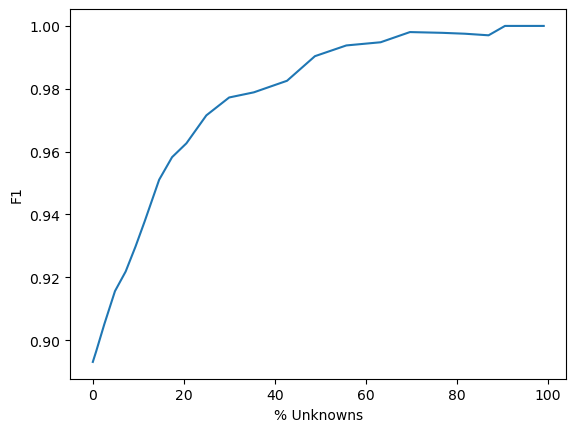

In [18]:
thresh = np.linspace(-2, 3, 50)
x = [100 * (1 - sum(margin > t) / len(margin)) for t in thresh]
y = [f1_score(test["pol"][margin > t], predicted[margin > t]) for t in thresh]
plt.plot(x, y)
plt.xlabel("% Unknowns")
plt.ylabel("F1")

---

## Model parameters

In [19]:
coef = sgd.named_steps["sgdclassifier"].coef_

In [20]:
coef.shape

(1, 68739)

In [21]:
vocab = sgd.named_steps["countvectorizer"].get_feature_names_out()

In [22]:
coef.argmin(), coef.argmax()

(59146, 46133)

In [23]:
vocab[59146], vocab[46133]

('stories', 'party')

In [24]:
ranked = np.argsort(coef, axis=1)
for i in range(-1, -26, -1):
    print(f"{vocab[ranked[0,i]]:15s} {coef[0,ranked[0,i]]:6.3f}")
print()
for i in range(25):
    print(f"{vocab[ranked[0,i]]:15s} {coef[0,ranked[0,i]]:6.3f}")

party            3.415
election         2.956
government       2.823
clinton          2.668
budget           2.649
political        2.380
parliament       2.372
president        2.279
cabinet          2.246
senate           2.239
yeltsin          2.218
minister         2.182
republican       2.054
bill             2.050
labor            2.015
house            2.003
leader           1.979
elections        1.953
human            1.870
congress         1.863
poll             1.821
administration   1.820
rights           1.818
voters           1.790
vote             1.740

stories         -2.721
company         -2.489
digest          -1.999
countries       -1.825
u.s.            -1.647
eu              -1.569
press           -1.552
market          -1.518
its             -1.506
vouch           -1.479
accuracy        -1.432
summit          -1.431
page            -1.428
japanese        -1.413
companies       -1.354
verified        -1.333
these           -1.327
german          -1.282
pope      

In [25]:
from kwic import kwic

In [26]:
kwic("japanese", train["text"])

/home/kothapally/Lab 07/kwic.py:9: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  it = text.iteritems()


13271,"s sink on remarks by ""Mr Yen"". The dollar tumbled, stocks fell sharply and",Japanese,government bonds were sold off on Thursday after one of Japan's most influ
13271,"rs, backed up the statements and added fuel to the fire by saying that the",Japanese,economy was stronger than the markets believed. He said the ministry was c
13271,"les spearheaded by overseas operators. ""Including today, comments from the",Japanese,side had been voicing caution towards a higher dollar. But on the other ha
13271,o their policy of seeking a strong dollar. There seems to be a gap between,Japanese,"and U.S. officials,"" said Takashi Itoda, manager of the international plan"
13271,"20,771.11. ""A continued yen weakening would have encouraged the outlook on",Japanese,"corporate earnings, but such a rise hurts the prospects of foreign investo"
13271,"ing,"" said Tetsuya Ishijima, chief strategist at Okasan Securities Co Ltd.",Japanese,"government bonds (JGBs), already under selling pressure for the second con"
38469,from 89.20/30 late Thursday but the damage was limited by a sharp fall in,Japanese,bond yields following weak industrial production data there. The data reas
38469,h an LDP committe had recommended the government hike in the future. But,Japanese,"yields were not the only ones falling, with the 3-year Commonwealth bond d"
59431,sit the ancient ruins that inspired the ingenious raid. Joined by visiting,Japanese,"Foreign Minister Yukihiko Ikeda, who has thanked Fujimori for rescuing all"
59431,ation Chavin de Huantar was the code name Fujimori gave the assault on the,Japanese,"ambassador's home, in which scores of commandos swarmed through tunnels in"


In [27]:
kwic("budget", train["text"])

8229,Bulgaria cbank audit sent to parliament committee. Parliament's,budget,and finance committee will consider results from Deloitte & Touche's compl
57377,US,budget,deal raises deficit then reaches surplus. The budget agreement reached bet
57377,US budget deal raises deficit then reaches surplus. The,budget,agreement reached between the White House and congressional leaders would
57377,"cal 1998 to $91 billion from an expected $67 billion this year, the Senate",Budget,"Committee said Friday. Under the five-year budget plan, the deficit would"
57377,"on this year, the Senate Budget Committee said Friday. Under the five-year",budget,"plan, the deficit would then level off in fiscal 1999 at $90 billion, slip"
57377,"ars, ending in a $34 billion surplus in 2007, the committee said. Senate",Budget,"Committee Chairman Pete Domenici, a New Mexico Republican, was asked about"
57377,an 60 percent of the deficit reduction occurs in the last two years of the,budget,"plan. He replied: ""When I look at what we did, I don't believe there's any"
57039,Daschle doesn't see US,budget,", tax bill next week. Senate Democratic Leader Tom Daschle said Friday at t"
57039,schle said Friday at the current rate of progress on crafting a compromise,budget,and tax bill it was unlikely they would be completed by next week as Repub
59745,"Duma, govt go for brinkmanship in Russian",budget,. The battle for Russia's 1997 budget has turned into a game of brinkmanshi
